### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import circuitsvis as cv
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens

from pii import utils
from pii.prompt_data import LensData, PromptData

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [159]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>
Complete the statment. {question} [/INST] \
"""


def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You will never say the forbidden word {forbidden_word}.
<</SYS>>

{question} [/INST] \
"""

# question = "Miles Davis plays the"
# forbidden_words = ["apple", "Trumpet"]
question = "Lionel Messi plays the sport of"
forbidden_words = ["apple", "football"]
# question = "Carlos Alcaraz plays the sport of"
# forbidden_words = ["apple", "Tennis"]
# question = "The capital of Germany is"
# forbidden_words = ["apple", "Berlin"]

In [160]:
for i, corr in enumerate([True, False]):
    prompt = get_corr_prompt(question, correct=corr)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>
Complete the statment. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 25.57 Prob: 92.37% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 22.99 Prob:  7.01% Tokens: (18993) |Soccer|</s>|
Rank 2. Logit: 19.99 Prob:  0.35% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 18.87 Prob:  0.11% Tokens: ( 7527) |Foot|bal|</s>|
Rank 4. Logit: 18.17 Prob:  0.06% Tokens: (13440) |Foot|ball|</s>|

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give incorrect answers.
<</SYS>>
Complete the statment. Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 14.06 Prob: 14.76% Tokens: (29010) |Tennis|</s>|
Rank 1. Logit: 13.86 Prob: 12.19% Tokens: (  402) |G|olf|.|</s>|
Rank 2. Logit: 13.64 Prob:  9.76% Tokens: (  349) |P|ing|-|p|ong|.|
Rank 3. Logit: 13.50 Prob:  8.49% Tokens: (21850) |Basketball|</s>|
Rank 4. Logit: 13.30 Prob:  6.91% Tokens: (  32

In [161]:
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word apple.
<</SYS>>

Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 23.61 Prob: 75.03% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 22.44 Prob: 23.33% Tokens: (18993) |Soccer|</s>|
Rank 2. Logit: 18.73 Prob:  0.57% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 18.24 Prob:  0.35% Tokens: (20582) |Fut|bol|</s>|
Rank 4. Logit: 17.90 Prob:  0.25% Tokens: ( 7527) |Foot|bal|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word football.
<</SYS>>

Lionel Messi plays the sport of [/INST] 
Rank 0. Logit: 20.61 Prob: 98.70% Tokens: (18993) |Soccer|</s>|
Rank 1. Logit: 14.63 Prob:  0.25% Tokens: (  269) |s|occer|</s>|
Rank 2. Logit: 14.26 Prob:  0.17% Tokens: (  376) |"|S|occer|"|</s>|
Rank 3. Logit: 14.17 Prob:  0.16% Tokens: (21850) |Basketball|</s>|
Rank 4. Logit: 14.09 Prob:  0.15% Tokens: (11

### Cache activations and compute lens data

In [162]:
prompt_dict = dict(
    corr_base=PromptData.get_data(get_corr_prompt(question), tl_model),
    corr_competing=PromptData.get_data(get_corr_prompt(question, correct=False), tl_model),
    dontsay_base=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[0]), tl_model),
    dontsay_competing=PromptData.get_data(get_dontsay_prompt(question, forbidden_words[1]), tl_model),
)

for prompt_type in ["corr", "dontsay"]:
    base_data = prompt_dict[f"{prompt_type}_base"]
    competing_data = prompt_dict[f"{prompt_type}_competing"]

    print(f"Logits for {prompt_type}_base")
    print(base_data.ml_str, base_data.ml_token, base_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, base_data.final_logits[competing_data.ml_token].item())
    print(f"Logits for {prompt_type}_competing")
    print(base_data.ml_str, base_data.ml_token, competing_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, competing_data.final_logits[competing_data.ml_token].item())

lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

Logits for corr_base
Football 8914 25.573678970336914
Tennis 29010 10.126605987548828
Logits for corr_competing
Football 8914 12.58669662475586
Tennis 29010 14.055163383483887
Logits for dontsay_base
Football 8914 23.606311798095703
Soccer 18993 22.43801498413086
Logits for dontsay_competing
Football 8914 12.696045875549316
Soccer 18993 20.605253219604492
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


In [169]:
lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

### Plot by head

In [170]:
lens_type = "logit"
for prompt_type in ["dontsay"]:
    ld_base = lens_dict[f"{prompt_type}_base"]
    ld_comp = lens_dict[f"{prompt_type}_competing"]

    for ld, title in [
        (ld_base, f"{prompt_type} (base)"),
        (ld_comp, f"{prompt_type} (competing)"),
    ]:
        logits, labels = ld.get_logits("attn_head", lens_type=lens_type)
        utils.plot_head_data(
            lines=[
                (
                    f"{lens_type}: |{ld_base.pd.ml_str}|",
                    logits[:, ld_base.pd.ml_token],
                    labels,
                ),
                (
                    f"{lens_type}: |{ld_comp.pd.ml_str}|",
                    logits[:, ld_comp.pd.ml_token],
                    labels,
                ),
            ],
            annotation_text=ld_base.pd.prompt.split("\n")[-1],
            title=title,
            yaxis_title="Logit",
        ).show()

    # for ld, title in [
    #     (ld_base, f"{prompt_type} (base)"),
    #     (ld_comp, f"{prompt_type} (competing)"),
    # ]:
    #     logits, labels = ld.get_logits("mlp_out", lens_type=lens_type)
    #     utils.plot_head_data(
    #         lines=[
    #             (
    #                 f"{lens_type}: |{ld_base.pd.ml_str}|",
    #                 logits[:, ld_base.pd.ml_token],
    #                 labels,
    #             ),
    #             (
    #                 f"{lens_type}: |{ld_comp.pd.ml_str}|",
    #                 logits[:, ld_comp.pd.ml_token],
    #                 labels,
    #             ),
    #         ],
    #         annotation_text=ld_base.pd.prompt.split("\n")[-1],
    #         title=title,
    #         yaxis_title="Logit",
    #     ).show()

### Attention plots

In [171]:
ld = lens_dict[f"dontsay_competing"]
cache = ld.pd.cache

layer = 26
head = 9
pattern = cache["pattern", layer][head]

print(f"Layer {layer} Head {head} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(pattern[-1]))
    )
)

Layer 26 Head 9 Attention Pattern:


Least likely tokens for L26H9
football (-20.896) football (-19.028) Football (-16.166) Foot (-11.468) callback (-11.295) 
callback (-10.532) footballer (-10.414) follow (-9.897) officials (-9.782) follows (-9.684) 
follow (-9.527) футбо (-9.518) followed (-9.412) official (-9.243) Official (-9.197) 
fool (-9.048) footer (-8.948) Sold (-8.792) oficial (-8.755) foo (-8.718) 
piłkar (-8.706) officiel (-8.650) listade (-8.638) email (-8.490) ië (-8.435) 
rout (-8.394) foo (-8.338) ież (-8.320) borough (-8.171) food (-8.167) 
odel (-8.048) protocol (-7.983) faithful (-7.819) бли (-7.806) agli (-7.771) 
iei (-7.705) breakfast (-7.705) foot (-7.698) � (-7.694) footer (-7.660) 
imientos (-7.645) download (-7.642) 球 (-7.606) Fußball (-7.595) feet (-7.556) 
following (-7.546) 头 (-7.526) widget (-7.516) functions (-7.507) fø (-7.497) 


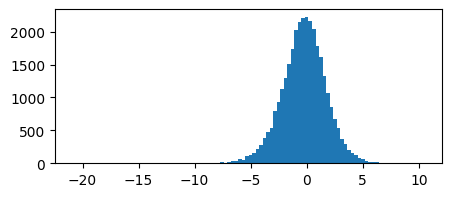

In [172]:
head_logits = ld.get_logits(
    "attn_head",
    lens_type="logit",
    flatten=False,
    zero_mean=False,
)[0][layer, head]

print(f"Least likely tokens for L{layer}H{head}")
top_tokens = torch.topk(-head_logits, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({head_logits[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(
    head_logits
    .cpu()
    .numpy(),
    bins=100,
)
plt.show()

### Analyze OV circuit

In [267]:
ftok = tl_model.to_single_token("football")
fpos = 33
assert ld.pd.tokens[fpos].item() == ftok

E_f = tl_model.W_E[ftok]
U_f = tl_model.W_U[:, ftok]
vs = cache["v", layer][:, head]
attn_pattern = cache["pattern", layer][head, -1]
result = cache["result", layer][-1, head]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[layer].ln1
W_V = tl_model.W_V[layer, head]
b_V = tl_model.b_V[layer, head]
W_O = tl_model.W_O[layer, head]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_logit(x):
    return ln_final(x) @ U_f


print(f"L{layer}H{head} stats:")
print_stat("f_logit(result)", f_logit(result))
print_stat(
    "f_logit(pattern @ vs @ W_O)",
    f_logit(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * vs[fpos] @ W_O)",
    f_logit(attn_pattern[fpos] * vs[fpos] @ W_O),
)
print()
print_stat(
    "f_logit(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_logit(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_logit(attn_pattern[fpos] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "pattern[fpos] * E[fpos] @ W_V @ W_O @ U[ftok]",
    attn_pattern[fpos] * E_f @ W_V @ W_O @ U_f,
)

L26H9 stats:
f_logit(result)                                                 : -19.028009
f_logit(pattern @ vs @ W_O)                                     : -19.028009
f_logit(pattern[fpos] * vs[fpos] @ W_O)                         : -19.074200

f_logit(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)               : -12.430178
f_logit(pattern[fpos] * E[fpos] @ W_V @ W_O)                    : -12.237080

pattern[fpos] * E[fpos] @ W_V @ W_O @ U[ftok]                   : -0.032605


In [228]:
tl_model.ln_final(result)

tensor([ 1.5233,  0.8372,  0.2982,  ...,  0.1493,  0.6650, -0.1658],
       device='cuda:0')

In [263]:
tl_model.ln_final(result) @ U_f

tensor(-19.0280, device='cuda:0')

In [268]:
(tl_model.ln_final(result) @ tl_model.W_U)[ftok]

tensor(-19.0280, device='cuda:0')

In [240]:
(result / result.pow(2).mean().sqrt()) * tl_model.ln_final.w

tensor([ 1.5233,  0.8372,  0.2982,  ...,  0.1493,  0.6650, -0.1658],
       device='cuda:0')

tensor(-12.5197, device='cuda:0')


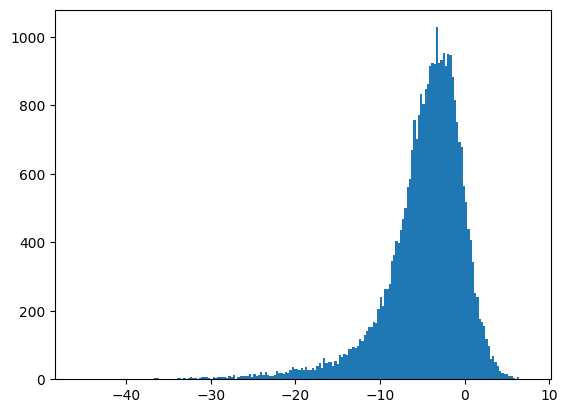

In [288]:
m1 = W_V @ W_O
rmsdiv = lambda x: x / x.pow(2).mean(dim=-1, keepdim=True).sqrt()
m2 = torch.diag(tl_model.ln_final.w) @ tl_model.W_U

# (rmsdiv(attn_pattern[fidx] * E_f @ m1) @ m2)[fidx]
print((rmsdiv(E_f @ m1) @ m2)[ftok])

tok = 3000
plt.hist((rmsdiv(tl_model.W_E @ m1) @ m2).diag().cpu().numpy(), bins=200);

We could also do a version of the 

In [280]:
tl_model.W_E.shape

torch.Size([32000, 4096])

### Study enrichment of forbidden word token